In [117]:
# CSV must have: id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate
# Use "../data/train.csv" if your dataset is there instead of dataset/train.csv
df = pd.read_csv("../data/dataset/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [118]:
df.shape

(159571, 8)

In [119]:
df["label"] = ( # If any toxic category is present, the comment is labeled as toxic (1)
    df["toxic"] |
    df["severe_toxic"] |
    df["obscene"] |
    df["threat"] |
    df["insult"] |
    df["identity_hate"]
)

**Data processing (for presentation)**  
- **CSV:** We use the training set with columns `id`, `comment_text`, and six toxicity flags (`toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, `identity_hate`). The same structure is in `../data/dataset/train.csv` or `../data/train.csv` depending on where you place the file.  
- **Binary label:** We set `label = 1` (toxic) if *any* of the six categories is 1; otherwise `label = 0` (non-toxic). This is a standard choice for binary toxicity detection on the Jigsaw/Wikipedia dataset and matches the goal of flagging any harmful comment.  
- **Text cleaning:** We lowercase, remove URLs, keep only letters and spaces, and remove English stopwords so the model sees consistent tokens and less noise.  
- **Train/test split:** We use `stratify=y` so the ~90% non-toxic / ~10% toxic ratio is preserved in both splits, giving a fair evaluation.

In [120]:
df["label"].value_counts() # Check the distribution of toxic vs non-toxic comments

label
0    143346
1     16225
Name: count, dtype: int64

In [121]:
df[["comment_text", "label"]].head() #to check which ones has toxic comment

,comment_text,label
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [122]:
import re
import nltk
from nltk.corpus import stopwords

In [123]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GIGABYTE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [124]:
stop_words = set(stopwords.words("english"))

def clean_text(text): # Function to clean and normalize text data
    text = text.lower()                      # lowercase
    text = re.sub(r"http\S+", "", text)      # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)     # remove punctuation & numbers
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords
    return " ".join(words)

In [125]:
df["clean_text"] = df["comment_text"].apply(clean_text) # Apply the cleaning function to all comments
df[["comment_text", "clean_text"]].head() # Compare original and cleaned text

,comment_text,clean_text
0,Explanation\r\nWhy the edits made under my use...,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really trying edit war guy constant...
3,"""\r\nMore\r\nI can't make any real suggestions...",cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page thats


## Exploratory Data Analysis

In [126]:
# Basic dataset info
df.info()
print("\nMissing values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   label          159571 non-null  int64 
 9   clean_text     159571 non-null  object
dtypes: int64(7), object(3)
memory usage: 12.2+ MB

Missing values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
label            0
clean_text       0
dtype: int64


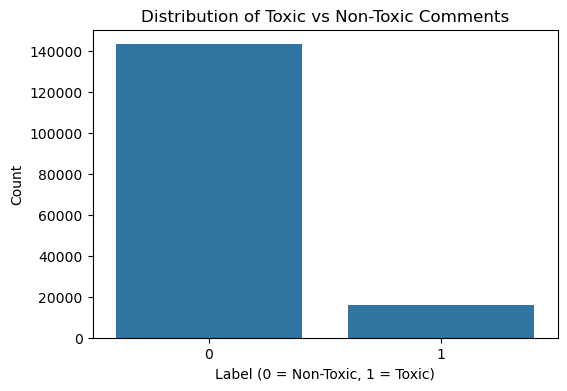

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# Label distribution (toxic vs non-toxic)
plt.figure(figsize=(6, 4))
sns.countplot(x=df["label"])
plt.title("Distribution of Toxic vs Non-Toxic Comments")
plt.xlabel("Label (0 = Non-Toxic, 1 = Toxic)")
plt.ylabel("Count")
plt.show()

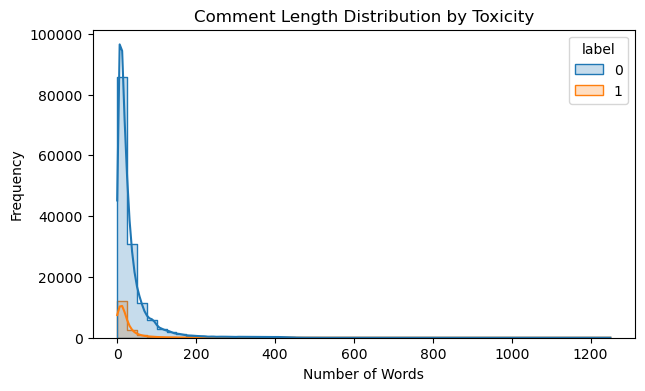

In [128]:
# Calculate comment lengths
df["comment_length"] = df["clean_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,4))
sns.histplot(
    data=df,
    x="comment_length",
    hue="label",
    bins=50,
    kde=True,
    element="step"
)
plt.title("Comment Length Distribution by Toxicity")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

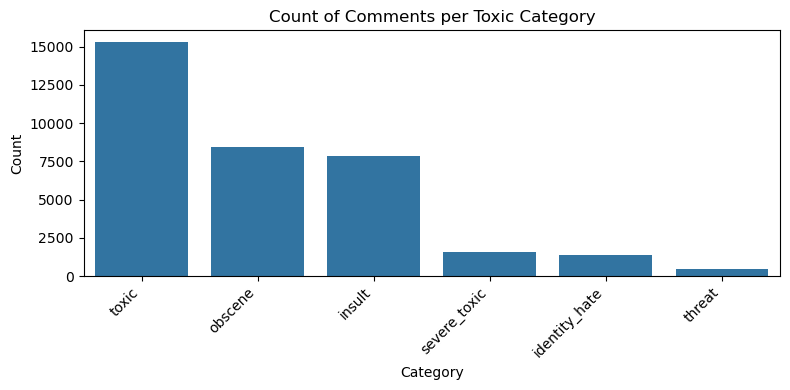

In [129]:
# Distribution of toxic subcategories (for multi-label view)
toxic_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
category_counts = df[toxic_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Count of Comments per Toxic Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

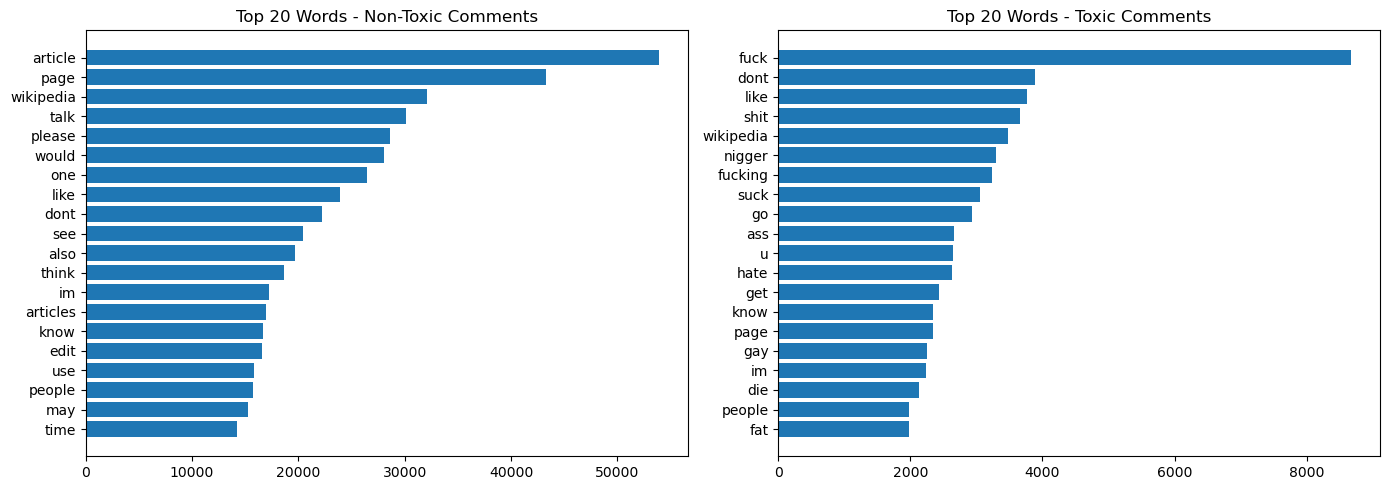

In [130]:
# Top 20 words in toxic vs non-toxic comments
from collections import Counter

toxic_text = " ".join(df[df["label"] == 1]["clean_text"].dropna()).split()
non_toxic_text = " ".join(df[df["label"] == 0]["clean_text"].dropna()).split()

toxic_counts = Counter(toxic_text).most_common(20)
non_toxic_counts = Counter(non_toxic_text).most_common(20)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh([w for w, _ in non_toxic_counts], [c for _, c in non_toxic_counts])
axes[0].set_title("Top 20 Words - Non-Toxic Comments")
axes[0].invert_yaxis()

axes[1].barh([w for w, _ in toxic_counts], [c for _, c in toxic_counts])
axes[1].set_title("Top 20 Words - Toxic Comments")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [131]:
# Word cloud for all comments combined
try:
    from wordcloud import WordCloud

    all_text = " ".join(df["clean_text"].dropna())

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate(all_text)

    plt.figure(figsize=(12, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.title("Word Cloud - All Comments")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

except ImportError:
    print("Install wordcloud: pip install wordcloud")


Install wordcloud: pip install wordcloud


In [132]:
# Word clouds for toxic vs non-toxic (requires: pip install wordcloud)
try:
    from wordcloud import WordCloud

    toxic_text = " ".join(df[df["label"] == 1]["clean_text"].dropna())
    non_toxic_text = " ".join(df[df["label"] == 0]["clean_text"].dropna())

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    wc_non = WordCloud(width=400, height=300, background_color="white").generate(non_toxic_text)
    axes[0].imshow(wc_non, interpolation="bilinear")
    axes[0].set_title("Word Cloud - Non-Toxic Comments")
    axes[0].axis("off")

    wc_toxic = WordCloud(width=400, height=300, background_color="white").generate(toxic_text)
    axes[1].imshow(wc_toxic, interpolation="bilinear")
    axes[1].set_title("Word Cloud - Toxic Comments")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
except ImportError:
    print("Install wordcloud for word clouds: pip install wordcloud")

Install wordcloud for word clouds: pip install wordcloud


In [133]:
from sklearn.model_selection import train_test_split

In [134]:
X = df["clean_text"] # X contains the cleaned text (features)
y = df["label"] # y contains the binary toxicity labels

In [135]:
X_train, X_test, y_train, y_test = train_test_split( # Split the data: 80% training, 20% testing
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # preserve class balance in both splits
)

In [136]:
print(len(X_train), len(X_test)) #quick check

127656 31915


## Model selection via cross-validation (training set only)

We use **cross-validation on the training set only** to select the best model (Logistic Regression vs Naive Bayes). The test set is held out and used **once** for final evaluation. We use **imbalanced-aware metrics** (F1, ROC-AUC, balanced accuracy) instead of accuracy, since only ~10% of comments are toxic.

CV f1 per fold (5-fold):



,Logistic Regression,Naive Bayes
Fold,,
Fold 1,0.7012,0.6773
Fold 2,0.7154,0.6625
Fold 3,0.7132,0.6688
Fold 4,0.7167,0.6691
Fold 5,0.7115,0.6640
Mean,0.7116,0.6683
Std,0.0055,0.0052


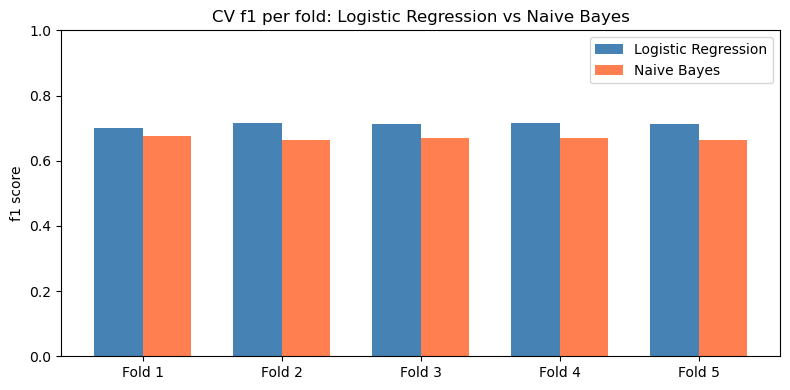

LR  mean f1: 0.7116 (+/- 0.0110)
NB  mean f1: 0.6683 (+/- 0.0103)
Selected: Logistic Regression


In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Pipelines with same TF-IDF config as before (so CV is comparable)
lr_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ("classifier", LogisticRegression(class_weight="balanced", max_iter=1000)),
])
nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ("classifier", MultinomialNB()),
])

# Cross-validate on training set only; use F1 (imbalanced-aware) not accuracy
cv_metric = "f1"  # alternatives: "roc_auc", "balanced_accuracy"
lr_cv = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring=cv_metric)
nb_cv = cross_val_score(nb_pipeline, X_train, y_train, cv=5, scoring=cv_metric)

# Per-fold comparison table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
n_folds = len(lr_cv)
cv_comparison = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(n_folds)],
    "Logistic Regression": np.round(lr_cv, 4),
    "Naive Bayes": np.round(nb_cv, 4),
})
cv_comparison = cv_comparison.set_index("Fold")
cv_comparison.loc["Mean"] = [round(lr_cv.mean(), 4), round(nb_cv.mean(), 4)]
cv_comparison.loc["Std"] = [round(lr_cv.std(), 4), round(nb_cv.std(), 4)]
print(f"CV {cv_metric} per fold (5-fold):\n")
display(cv_comparison)

# Bar chart: LR vs NB per fold
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(n_folds)
w = 0.35
ax.bar(x - w/2, lr_cv, w, label="Logistic Regression", color="steelblue")
ax.bar(x + w/2, nb_cv, w, label="Naive Bayes", color="coral")
ax.set_xticks(x)
ax.set_xticklabels([f"Fold {i+1}" for i in range(n_folds)])
ax.set_ylabel(f"{cv_metric} score")
ax.set_ylim(0, 1.0)
ax.set_title(f"CV {cv_metric} per fold: Logistic Regression vs Naive Bayes")
ax.legend()
plt.tight_layout()
plt.show()

print(f"LR  mean {cv_metric}: {lr_cv.mean():.4f} (+/- {lr_cv.std() * 2:.4f})")
print(f"NB  mean {cv_metric}: {nb_cv.mean():.4f} (+/- {nb_cv.std() * 2:.4f})")
best_pipeline = lr_pipeline if lr_cv.mean() >= nb_cv.mean() else nb_pipeline
print(f"Selected: {'Logistic Regression' if best_pipeline is lr_pipeline else 'Naive Bayes'}")

In [138]:
# Fit best pipeline on full training set (test set still untouched)
best_pipeline.fit(X_train, y_train)
vectorizer = best_pipeline.named_steps["tfidf"]
best_model = best_pipeline.named_steps["classifier"]

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
test_preds = best_model.predict(X_test_tfidf)
# For compatibility with downstream cells that use lr_preds
lr_preds = test_preds

In [139]:
from sklearn.metrics import (
    classification_report,
    f1_score,
    roc_auc_score,
    balanced_accuracy_score,
)

# Single evaluation on test set (imbalanced-aware metrics)
print("Test set evaluation (imbalanced-aware metrics):\n")
print(classification_report(y_test, test_preds, target_names=["Non-toxic", "Toxic"]))
print(f"F1 (binary, positive class): {f1_score(y_test, test_preds):.4f}")
print(f"Balanced accuracy:           {balanced_accuracy_score(y_test, test_preds):.4f}")
if hasattr(best_model, "predict_proba"):
    probs = best_model.predict_proba(X_test_tfidf)[:, 1]
    print(f"ROC-AUC:                     {roc_auc_score(y_test, probs):.4f}")

Test set evaluation (imbalanced-aware metrics):

              precision    recall  f1-score   support

   Non-toxic       0.98      0.93      0.96     28670
       Toxic       0.60      0.86      0.70      3245

    accuracy                           0.93     31915
   macro avg       0.79      0.90      0.83     31915
weighted avg       0.94      0.93      0.93     31915

F1 (binary, positive class): 0.7041
Balanced accuracy:           0.8957
ROC-AUC:                     0.9636


In [140]:
X_train_tfidf.shape  # quick check (from best_pipeline above)

(127656, 10000)

In [141]:
import pickle

In [142]:
# Save the trained model to the models folder
with open("../models/model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [143]:
# Save the TF-IDF vectorizer
with open("../models/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

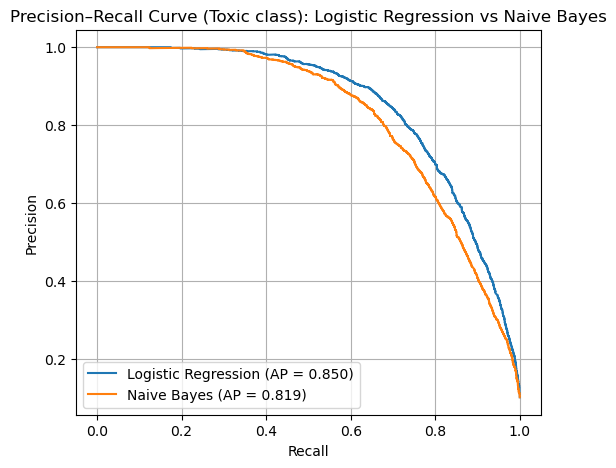

In [158]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

# Precision–Recall: Best model vs Naive Bayes (comparison)
plt.figure(figsize=(6, 5))
if hasattr(best_model, "predict_proba"):
    scores_best = best_model.predict_proba(X_test_tfidf)[:, 1]
    prec_best, rec_best, _ = precision_recall_curve(y_test, scores_best)
    ap_best = average_precision_score(y_test, scores_best)
    plt.plot(rec_best, prec_best, label=f"Logistic Regression (AP = {ap_best:.3f})")
nb_pr = MultinomialNB()
nb_pr.fit(X_train_tfidf, y_train)
scores_nb = nb_pr.predict_proba(X_test_tfidf)[:, 1]
prec_nb, rec_nb, _ = precision_recall_curve(y_test, scores_nb)
ap_nb = average_precision_score(y_test, scores_nb)
plt.plot(rec_nb, prec_nb, label=f"Naive Bayes (AP = {ap_nb:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Toxic class): Logistic Regression vs Naive Bayes")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 400x400 with 0 Axes>

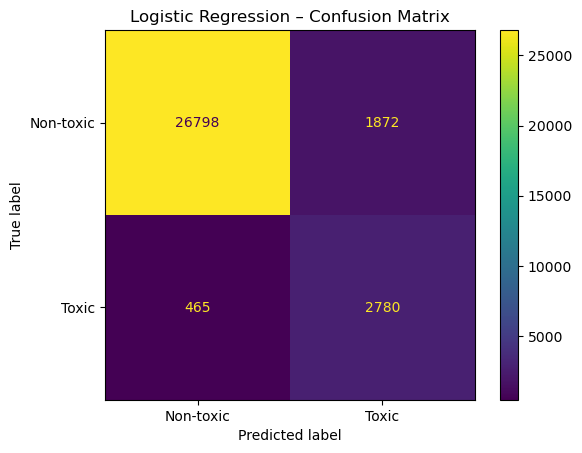

<Figure size 400x400 with 0 Axes>

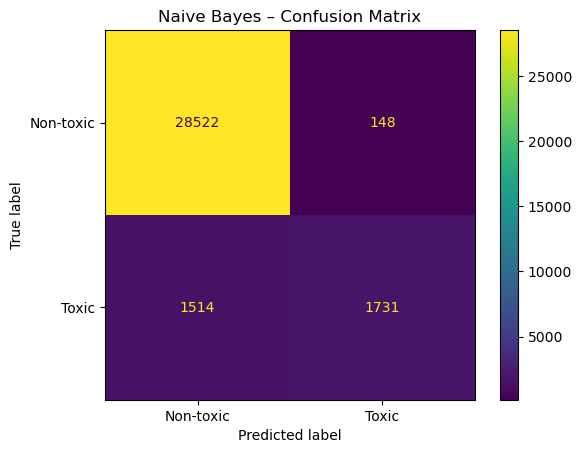

In [167]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

# Confusion matrix for best model (selected by CV)
best_cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=["Non-toxic", "Toxic"])
plt.figure(figsize=(4, 4))
disp.plot(values_format='d')
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

# Confusion matrix for Naive Bayes (same features for fair comparison)
nb_cm_clf = MultinomialNB()
nb_cm_clf.fit(X_train_tfidf, y_train)
nb_cm_preds = nb_cm_clf.predict(X_test_tfidf)
nb_cm = confusion_matrix(y_test, nb_cm_preds)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=["Non-toxic", "Toxic"])
plt.figure(figsize=(4, 4))
disp_nb.plot(values_format='d')
plt.title("Naive Bayes – Confusion Matrix")
plt.show()

In [164]:
import pandas as pd

# Build a DataFrame aligned with the test set
test_df = pd.DataFrame({
    "clean_text": X_test,
    "true_label": y_test,
    "lr_pred": lr_preds
})

# If the original dataframe has the raw comment text, join it back for easier inspection
if "comment_text" in df.columns:
    test_df = test_df.join(df["comment_text"], how="left")

# False negatives: truly toxic (1) but predicted as non-toxic (0)
fn_df = test_df[(test_df["true_label"] == 1) & (test_df["lr_pred"] == 0)]

# False positives: truly non-toxic (0) but predicted as toxic (1)
fp_df = test_df[(test_df["true_label"] == 0) & (test_df["lr_pred"] == 1)]

print("Sample FALSE NEGATIVES (toxic predicted as non-toxic):")
display(fn_df.sample(min(10, len(fn_df)), random_state=42)[["comment_text", "clean_text", "true_label", "lr_pred"]])

print("Sample FALSE POSITIVES (non-toxic predicted as toxic):")
display(fp_df.sample(min(10, len(fp_df)), random_state=42)[["comment_text", "clean_text", "true_label", "lr_pred"]])

Sample FALSE NEGATIVES (toxic predicted as non-toxic):


,comment_text,clean_text,true_label,lr_pred
115787,"""YOUR SERIOUS MENTAL ILLNESS AND ADDICTION==\r...",serious mental illness addiction contructive t...,1,0
55350,"Mel Etitis, Are you retarded? \r\n\r\nWhat is ...",mel etitis retarded problem seriously websites...,1,0
33789,"""\r\n\r\n A barnstar for you! \r\n\r\n The Or...",barnstar original barnstar mad know effort edi...,1,0
151473,Just incase anyone is interested my favourite ...,incase anyone interested favourite hobby playi...,1,0
104453,"""\r\nYou are by far the most unhelpful, ungrac...",far unhelpful ungracious administrator ever de...,1,0
99398,"Nig, Nigs? \r\n\r\nNig, Nigs? What about Nig, ...",nig nigs nig nigs nig nigs hear sometimes peop...,1,0
74513,This article contains so much garbage that a s...,article contains much garbage single editor ca...,1,0
26163,Would you please keep your ridiculous and unfo...,would please keep ridiculous unfounded accusat...,1,0
34574,Oppose' - I also oppose the hatnote and withou...,oppose also oppose hatnote without hatnote red...,1,0
122018,The JPS... are you for real? This conversation...,jps real conversation youve looks bit odd work...,1,0


Sample FALSE POSITIVES (non-toxic predicted as toxic):


,comment_text,clean_text,true_label,lr_pred
117644,"""There goes another one calling Hot Topic an e...",goes another one calling hot topic emo goth st...,0,1
93110,Goodbye Everyone I am Blocked From Wikia \r\n\...,goodbye everyone blocked wikia however still s...,0,1
21316,Hard Ball \r\n\r\nAwww you boys seem awfully t...,hard ball awww boys seem awfully tough id sugg...,0,1
115842,"""\r\n\r\n Stop vandalising maoist wiki page \r...",stop vandalising maoist wiki page stop vandali...,0,1
108607,That reply you sent me made me very sad. I sai...,reply sent made sad said clearly dont want sta...,0,1
19061,No about 50% of the kids that attended these s...,kids attended schools murdered canadian govern...,0,1
135553,I disagree. I still have major problems with t...,disagree still major problems article doublech...,0,1
4294,"""\r\nKeep kidding yourself. Thats the fanboy s...",keep kidding thats fanboy site using third ref...,0,1
109459,""", 6 August 2010 (UTC)\r\n\r\n""""Well Alex, you...",august utc well alex call still right know ene...,0,1
67996,"So because the name is CAN bus, we should call...",name bus call controller area network typical ...,0,1


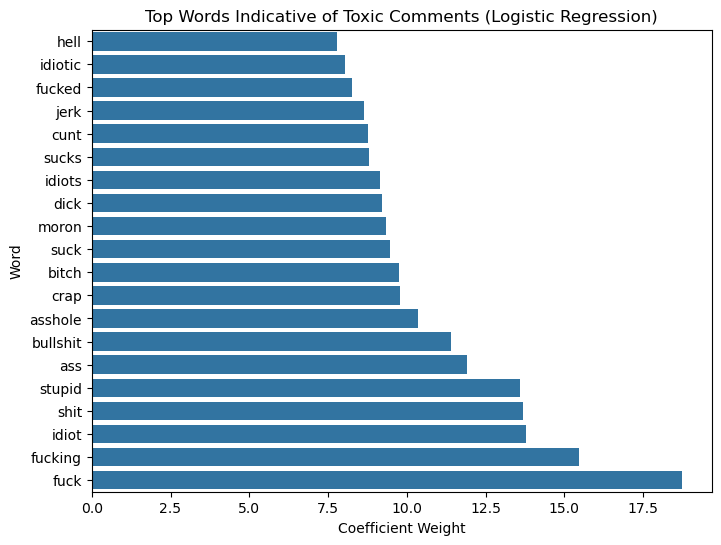

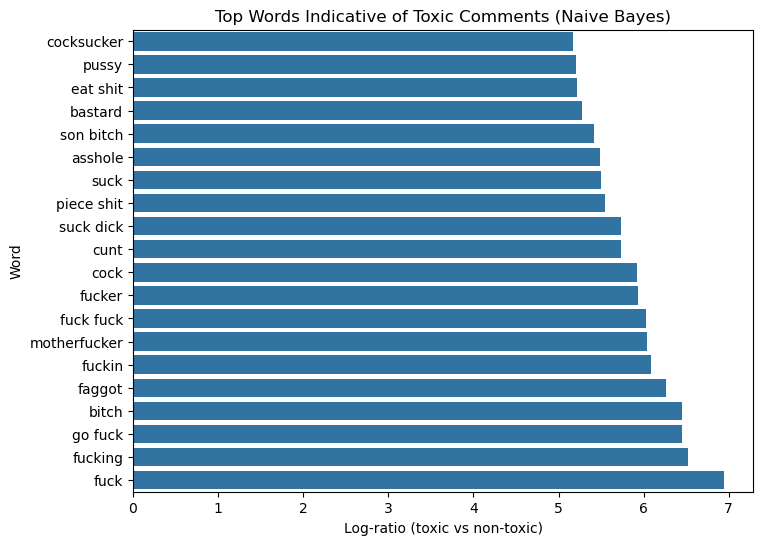

In [165]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB

# Get feature names from TF-IDF
feature_names = vectorizer.get_feature_names_out()

# --- Logistic Regression: top words (coefficients) ---
coefficients = best_model.coef_[0]
top_toxic_indices_lr = np.argsort(coefficients)[-20:]
top_toxic_words_lr = feature_names[top_toxic_indices_lr]
top_toxic_scores_lr = coefficients[top_toxic_indices_lr]
plt.figure(figsize=(8, 6))
sns.barplot(x=top_toxic_scores_lr, y=top_toxic_words_lr)
plt.title("Top Words Indicative of Toxic Comments (Logistic Regression)")
plt.xlabel("Coefficient Weight")
plt.ylabel("Word")
plt.show()

# --- Naive Bayes: top words (log-ratio: more positive = more indicative of toxic) ---
nb_top = MultinomialNB()
nb_top.fit(X_train_tfidf, y_train)
# Log-ratio: log P(word|toxic) - log P(word|non-toxic); positive = more in toxic class
log_prob_toxic = nb_top.feature_log_prob_[1]
log_prob_nontoxic = nb_top.feature_log_prob_[0]
log_ratio = log_prob_toxic - log_prob_nontoxic
top_toxic_indices_nb = np.argsort(log_ratio)[-20:]
top_toxic_words_nb = feature_names[top_toxic_indices_nb]
top_toxic_scores_nb = log_ratio[top_toxic_indices_nb]
plt.figure(figsize=(8, 6))
sns.barplot(x=top_toxic_scores_nb, y=top_toxic_words_nb)
plt.title("Top Words Indicative of Toxic Comments (Naive Bayes)")
plt.xlabel("Log-ratio (toxic vs non-toxic)")
plt.ylabel("Word")
plt.show()

Test set metrics: Logistic Regression vs Naive Bayes


,Metric,Logistic Regression,Naive Bayes
0,Accuracy,0.9268,0.9479
1,"F1 (binary, toxic)",0.7041,0.6756
2,F1 (macro),0.8311,0.8237
3,F1 (weighted),0.9324,0.9416
4,Precision (macro),0.7903,0.9354
5,Recall (macro),0.8957,0.7641
6,Balanced accuracy,0.8957,0.7641
7,ROC-AUC,0.9636,0.9529
8,Average precision,0.8497,0.8185


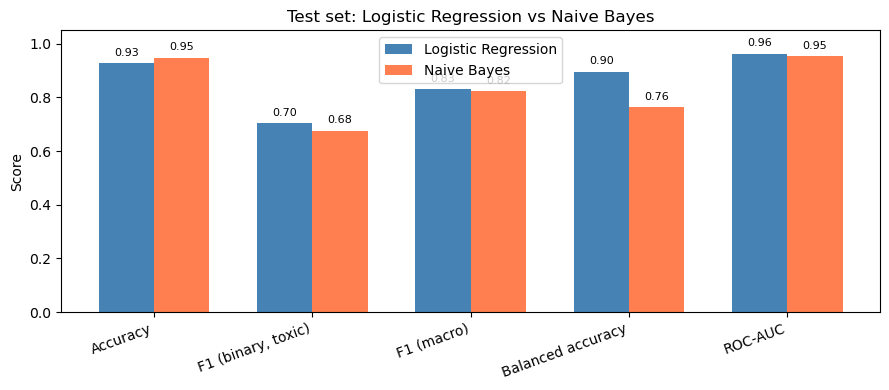


Per-class metrics (Logistic Regression)


,Class,Precision,Recall,F1
0,Non-toxic,0.9829,0.9347,0.9582
1,Toxic,0.5976,0.8567,0.7041



Per-class metrics (Naive Bayes)


,Class,Precision,Recall,F1
0,Non-toxic,0.9496,0.9948,0.9717
1,Toxic,0.9212,0.5334,0.6756


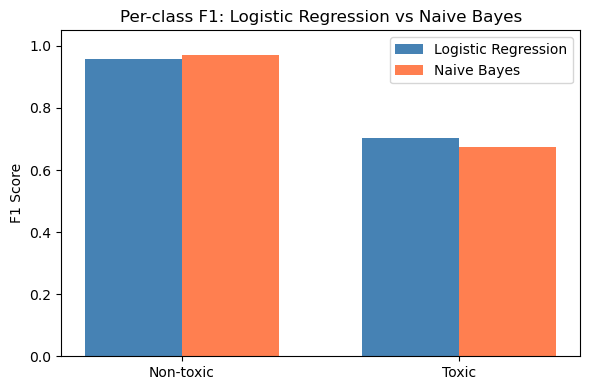

In [166]:
# --- Test metrics summary: Best model vs Naive Bayes (table + graphs) ---
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    average_precision_score,
)
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fit Naive Bayes on same features for fair comparison
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)
nb_preds = nb_clf.predict(X_test_tfidf)
nb_probs = nb_clf.predict_proba(X_test_tfidf)[:, 1] if hasattr(nb_clf, "predict_proba") else None

def compute_metrics(y_true, y_pred, probs=None):
    d = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (binary, toxic)": f1_score(y_true, y_pred, pos_label=1, zero_division=0),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "Precision (macro)": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall (macro)": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "Balanced accuracy": balanced_accuracy_score(y_true, y_pred),
    }
    if probs is not None:
        d["ROC-AUC"] = roc_auc_score(y_true, probs)
        d["Average precision"] = average_precision_score(y_true, probs)
    return d

best_probs = best_model.predict_proba(X_test_tfidf)[:, 1] if hasattr(best_model, "predict_proba") else None
metrics_best = compute_metrics(y_test, test_preds, best_probs)
metrics_nb = compute_metrics(y_test, nb_preds, nb_probs)

# Comparison table: Best model vs Naive Bayes
metric_names = list(metrics_best.keys())
comparison_df = pd.DataFrame({
    "Metric": metric_names,
    "Logistic Regression": [round(metrics_best[m], 4) for m in metric_names],
    "Naive Bayes": [round(metrics_nb[m], 4) for m in metric_names],
})
print("Test set metrics: Logistic Regression vs Naive Bayes\n" + "=" * 50)
display(comparison_df)

# Grouped bar chart: Best model vs Naive Bayes (main metrics)
plot_metrics = ["Accuracy", "F1 (binary, toxic)", "F1 (macro)", "Balanced accuracy", "ROC-AUC"]
plot_metrics = [m for m in plot_metrics if m in metrics_best]
x = np.arange(len(plot_metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(9, 4))
bars1 = ax.bar(x - width/2, [metrics_best[m] for m in plot_metrics], width, label="Logistic Regression", color="steelblue")
bars2 = ax.bar(x + width/2, [metrics_nb[m] for m in plot_metrics], width, label="Naive Bayes", color="coral")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_xticks(x)
ax.set_xticklabels(plot_metrics, rotation=20, ha="right")
ax.set_title("Test set: Logistic Regression vs Naive Bayes")
ax.legend()
for bars in (bars1, bars2):
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{bar.get_height():.2f}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

# Per-class Precision, Recall, F1 (table + bar)
precision_per_class = precision_score(y_test, test_preds, average=None, zero_division=0)
recall_per_class = recall_score(y_test, test_preds, average=None, zero_division=0)
f1_per_class = f1_score(y_test, test_preds, average=None, zero_division=0)
per_class_df = pd.DataFrame(
    {
        "Class": ["Non-toxic", "Toxic"],
        "Precision": precision_per_class,
        "Recall": recall_per_class,
        "F1": f1_per_class,
    }
)
per_class_df = per_class_df.round(4)
print("\nPer-class metrics (Logistic Regression)\n" + "=" * 40)
display(per_class_df)

# Per-class for Naive Bayes
nb_prec = precision_score(y_test, nb_preds, average=None, zero_division=0)
nb_rec = recall_score(y_test, nb_preds, average=None, zero_division=0)
nb_f1 = f1_score(y_test, nb_preds, average=None, zero_division=0)
per_class_nb_df = pd.DataFrame({
    "Class": ["Non-toxic", "Toxic"],
    "Precision": nb_prec,
    "Recall": nb_rec,
    "F1": nb_f1,
}).round(4)
print("\nPer-class metrics (Naive Bayes)\n" + "=" * 40)
display(per_class_nb_df)

# Side-by-side bar: F1 by class (Best vs NB)
fig2, ax2 = plt.subplots(figsize=(6, 4))
classes = ["Non-toxic", "Toxic"]
x_pos = np.arange(len(classes))
w = 0.35
ax2.bar(x_pos - w/2, per_class_df["F1"], w, label="Logistic Regression", color="steelblue")
ax2.bar(x_pos + w/2, per_class_nb_df["F1"], w, label="Naive Bayes", color="coral")
ax2.set_xticks(x_pos)
ax2.set_xticklabels(classes)
ax2.set_ylabel("F1 Score")
ax2.set_ylim(0, 1.05)
ax2.set_title("Per-class F1: Logistic Regression vs Naive Bayes")
ax2.legend()
plt.tight_layout()
plt.show()